In [1]:
import numpy as np, pandas as pd
import sys, os
import time, datetime
import random
import matplotlib.pyplot as plt
import pyomo.environ
from pyomo.core import *
from pyomo.opt import SolverFactory

# Checkout results of minority majority bias sim

In [2]:
def GDPC(eps, exact_counts):
        """ Geometric DP Counts
        Parameters
        ----------
        eps : float-able
        exact_counts : pd.Series
        
        Results
        -------
        returns dp_counts, a pd.Series with index matching exact_counts"""
        
        z = float(eps)

        all_errors = (np.random.geometric(z, size=len(exact_counts))
                        - np.random.geometric(z, size=len(exact_counts)))
        dp_counts = exact_counts + all_errors
        return dp_counts


In [3]:
def nonnegative_optimize(imprecise_counts, control_total):
    """optimize the imprecise counts so that they sum to
    the control total and are non-negative
    
    Parameters
    ----------
    imprecise_counts : list-like of floats
    control_total : float
    
    Results
    -------
    returns optimized_counts, which are close to imprecise counts,
    but not negative, and match control total in aggregate
    """
    imprecise_counts = list(imprecise_counts)
    
    model = ConcreteModel()
    model.I = range(len(imprecise_counts))
    model.x = Var(model.I, within=NonNegativeReals)
    model.objective = Objective(
        expr=sum((model.x[i] - imprecise_counts[i])**2 for i in model.I))
    model.constraint = Constraint(
        expr=summation(model.x) == control_total)
    
    solver = SolverFactory('ipopt')
    results = solver.solve(model, options={'acceptable_tol':1e-4}, tee=False)
    optimized_counts = [value(model.x[i]) for i in model.I]
        
    return np.array(optimized_counts)

In [4]:
def main(optimizer, a, b, pct_minority, segregation_factor, K, N, epsilon, seed):
    """ run full algorithm to add geometric noise then optimize to remove negatives
    over a population with minority and majority subpopulations
    for which the minority pop is in the majority in some "counties"
    
    Parameters
    ----------
    a,b = parameters of beta distribution for # individulas per county
    seg_factor = degree of segretation, county level
    pct_minority = pct of population in the minority
    K = total population size
    epsilon = parameter for amount of privacy in overall counts
    
    Output
    ------
    array with:
    which areas were originally minority majority, minority minority
    precise minority counts, precise majority counts
    dp minority counts, dp majority counts
    nn minority counts, nn majority counts
    """
    np.random.seed(seed)
    n_k = np.random.beta(a, b, K) # number of individuals in area k
    n_k *= N/sum(n_k)
    total_pop = sum(n_k)

    minority_share = np.random.beta(pct_minority/segregation_factor,
                                    (1-pct_minority)/segregation_factor, size=K)
    minmaj_area = minority_share >= 0.5
    minmin_area = minority_share < 0.5
    # simulate race-/location-stratified counts
    precise_minority_count = np.random.binomial(n_k.astype(int), minority_share)
    precise_majority_count = n_k - precise_minority_count

    # add Geometric noise, to make counts differentially private
    dp_minority_count = GDPC(epsilon, precise_minority_count)
    dp_majority_count = GDPC(epsilon, precise_majority_count)

    # optimize to find counts that are "close" to the dp counts,
    # are non-negative, and have race-stratified sums that match the precise
    # total sum for both minority and majority groups

    nn_minority_count = optimizer(dp_minority_count, precise_minority_count.sum())
    nn_majority_count = optimizer(dp_majority_count, precise_majority_count.sum())

    return[minmaj_area,minmin_area,
           precise_minority_count,precise_majority_count,
           dp_minority_count,dp_majority_count,
           nn_minority_count,nn_majority_count]

In [5]:
def see_minmaj_distr(main_obj, version, use_log = False):
    """ Plot minority counts
    
    Parameters
    ----------
    output array of "main"
    whether to use precise, dp, or nn counts
    whether to plot y axis on a log scale
    
    Output
    ------
    histogram of selected counts
    with total minority counts
    overlaid with the distribution of minority counts in previously minority majority areas
    """
    minmaj_area,minmin_area = main_obj[0], main_obj[1]
    if version=="precise":
        x1, x2 = 2,3
    elif version=="dp":
        x1, x2 = 4,5
    elif version=="nn":
        x1, x2 = 6,7
    else:
        raise Exception("oops; version must be in ['precise','dp','nn']")
    minority_count,majority_count = main_obj[x1], main_obj[x2]
    plt.hist(minority_count, bins=100)
    plt.hist(minority_count[minmaj_area], bins = 100, log = use_log)
    title = version + " minority count distribution; minority majority counties overlaid"
    if use_log:
        title = "log scale: " + title
    plt.title(title)
    plt.show()
    plt.close()

In [6]:
def summaries(main_obj):
    """     
    Parameters
    ----------
    output array of "main"
    
    Output
    ------
    Table with summaries of total counts for
    {precise, dp, nn} x {minority majority areas, min min areas}
    """
    #grab outputs
    minmaj_area,minmin_area = main_obj[0], main_obj[1]
    precise_minority_count,precise_majority_count = main_obj[2], main_obj[3]
    dp_minority_count,dp_majority_count = main_obj[4], main_obj[5]
    nn_minority_count,nn_majority_count = main_obj[6], main_obj[7]
    
    # get stats
    minmaj_count, minmin_count = minmaj_area.sum(), minmin_area.sum()
    
    precise_total_minmaj, precise_mean_minmaj = precise_minority_count[minmaj_area].sum(), precise_minority_count[minmaj_area].sum()/minmaj_count
    dp_total_minmaj, dp_mean_minmaj = dp_minority_count[minmaj_area].sum(), dp_minority_count[minmaj_area].sum()/minmaj_count
    nn_total_minmaj, nn_mean_minmaj = nn_minority_count[minmaj_area].sum(), nn_minority_count[minmaj_area].sum()/minmaj_count
    minmaj_change = 1-(nn_total_minmaj/dp_total_minmaj)
    
    precise_total_minmin, precise_mean_minmin = precise_minority_count[minmin_area].sum(), precise_minority_count[minmin_area].sum()/minmin_count
    dp_total_minmin, dp_mean_minmin = dp_minority_count[minmin_area].sum(), dp_minority_count[minmin_area].sum()/minmin_count
    nn_total_minmin, nn_mean_minmin = nn_minority_count[minmin_area].sum(), nn_minority_count[minmin_area].sum()/minmin_count
    minmin_change = 1-(nn_total_minmin/dp_total_minmin)
    
    #compile table
    summary = pd.DataFrame(columns=['precise','dp ','non-neg','pct change'],
                           index=["minority majority totals","minority minority totals"],
                           data = [[precise_total_minmaj,dp_total_minmaj,nn_total_minmaj,minmaj_change],
                     [precise_total_minmin,dp_total_minmin,nn_total_minmin,minmin_change]])
    return summary.T

## checkout how distribution changes as noise added then optimization is run.

In [7]:
pop_3e3 = main(nonnegative_optimize, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e3, epsilon=0.1, seed=1)
pop_3e5 = main(nonnegative_optimize, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e5, epsilon=0.1, seed=1)
pop_3e7 = main(nonnegative_optimize, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e7, epsilon=0.1, seed=1)

In [12]:
summaries(pop_3e3)

,minority majority totals,minority minority totals
precise,50.000000,37.000000
dp,-225.000000,-780.000000
non-neg,12.333344,74.666755
pct change,1.054815,1.095727


In [32]:
minority_count_3e3 = pop_3e3[2]
print(f'minority total: {minority_count_3e3.sum()}')
q99 = np.quantile(minority_count_3e3, .99)
print(f'99th quantile: {q99}')

minority total: 87
99th quantile: 0.0


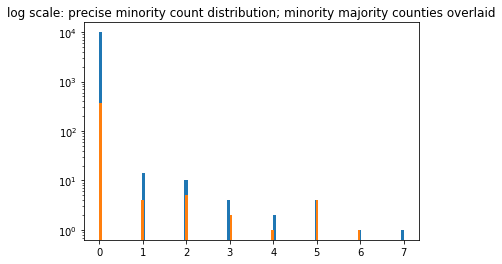

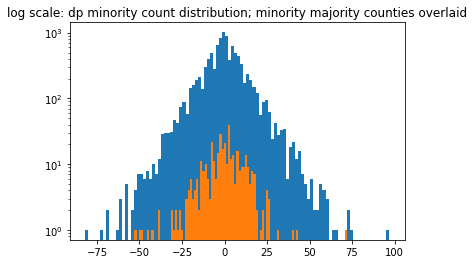

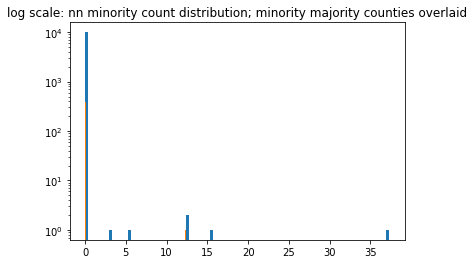

In [9]:
see_minmaj_distr(pop_3e3, version = "precise", use_log = True)
see_minmaj_distr(pop_3e3, version = "dp", use_log = True)
see_minmaj_distr(pop_3e3, version = "nn", use_log = True)

In [22]:
summaries(pop_3e5)

,minority majority totals,minority minority totals
precise,5649.000000,4190.000000
dp,5604.000000,3111.000000
non-neg,4826.143845,5012.856245
pct change,0.138804,-0.611333


In [70]:
minority_count_3e5 = pop_3e5[2]
print(f'minority precise total: {minority_count_3e5.sum()}')
q99 = np.quantile(minority_count_3e5, .99)
print(f'99th quantile: {q99}')

# precise minority maj vs min min count above and below 99th quantile
minmaj_3e5 = minority_count_3e5[pop_3e5[0]]
minmin_3e5 = minority_count_3e5[pop_3e5[1]]

minmaj_above99_3e5 = minmaj_3e5[minmaj_3e5>q99]
minmin_above99_3e5 = minmin_3e5[minmin_3e5>q99]

minmaj_below99_3e5 = minmaj_3e5[minmaj_3e5<=q99]
minmin_below99_3e5 = minmin_3e5[minmin_3e5<=q99]

print("DP aggregate counts in counties with counts above and below 99th quantile, \n \
      and from minority maj vs minority minority counties")
pop_3e5_above_below99 = pd.DataFrame(columns = ['above','below'], index=['min maj','min min'],
    data = [[minmaj_above99_3e5.sum(),minmaj_below99_3e5.sum()],
            [minmin_above99_3e5.sum(),minmin_below99_3e5.sum()]])
pop_3e5_above_below99

minority precise total: 9839
99th quantile: 7.0
DP aggregate counts in counties with counts above and below 99th quantile, 
       and from minority maj vs minority minority counties


,above,below
min maj,5612,37
min min,3928,262


In [71]:
minority_dp_count_3e5 = pop_3e5[4]
print(f'minority dp total: {minority_dp_count_3e5.sum()}')
q99_dp = np.quantile(minority_dp_count_3e5, .99)
print(f'99th quantile: {q99}')

# dp minority maj vs min min count above and below 99th quantile
minmaj_dp_3e5 = minority_dp_count_3e5[pop_3e5[0]]
minmin_dp_3e5 = minority_dp_count_3e5[pop_3e5[1]]

minmaj_above99_dp_3e5 = minmaj_dp_3e5[minmaj_dp_3e5>q99_dp]
minmin_above99_dp_3e5 = minmin_dp_3e5[minmin_dp_3e5>q99_dp]

minmaj_below99_dp_3e5 = minmaj_dp_3e5[minmaj_dp_3e5<=q99_dp]
minmin_below99_dp_3e5 = minmin_dp_3e5[minmin_dp_3e5<=q99_dp]

print("DP aggregate counts in counties with counts above and below 99th quantile, \n and from minority maj vs minority minority counties")
pop_3e5_dp_above_below99 = pd.DataFrame(columns = ['above','below'], index=['min maj','min min'],
    data = [[minmaj_above99_dp_3e5.sum(),minmaj_below99_dp_3e5.sum()],[minmin_above99_dp_3e5.sum(),minmin_below99_dp_3e5.sum()]])
pop_3e5_dp_above_below99

minority dp total: 8715
99th quantile: 7.0
DP aggregate counts in counties with counts above and below 99th quantile, 
 and from minority maj vs minority minority counties


,above,below
min maj,5478,126
min min,5735,-2624


In [74]:
print("so that pattern we're looking for in the precise counts would be:")

aian_ = pd.DataFrame(columns=['>99th q','<=99th q'], index = ['AIAN urban','AIAN rural'],
                           data = [['large','smaller'],['large','small']])
hypoth_urban

so that pattern we're looking for in the precise counts would be:


,>99th q,<=99th q
AIAN urban,large,smaller
AIAN rural,large,small


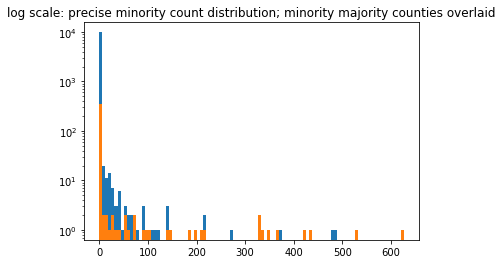

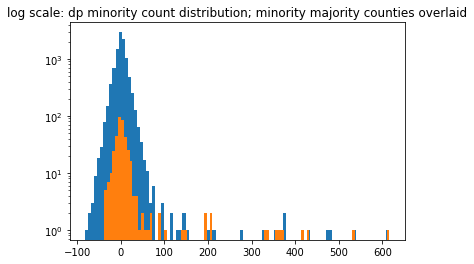

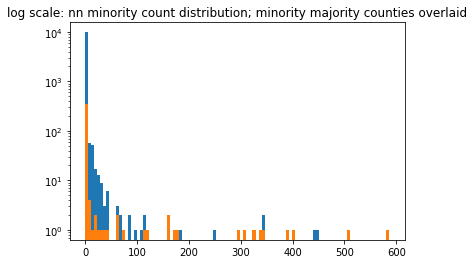

In [11]:
see_minmaj_distr(pop_3e5, version = "precise", use_log = True)
see_minmaj_distr(pop_3e5, version = "dp", use_log = True)
see_minmaj_distr(pop_3e5, version = "nn", use_log = True)

In [10]:
summaries(pop_3e7)

,minority majority totals,minority minority totals
precise,566663.000000,423290.000000
dp,566633.000000,422844.000000
non-neg,565708.712781,424244.287219
pct change,0.001631,-0.003312


In [55]:
minority_dp_count_3e7 = pop_3e7[4]
print(f'minority dp total: {minority_dp_count_3e7.sum()}')
q99_dp_3e7 = np.quantile(minority_dp_count_3e7, .99)
print(f'99th quantile: {q99}')

# dp minority maj vs min min count above and below 99th quantile
minmaj_dp_3e7 = minority_dp_count_3e7[pop_3e7[0]]
minmin_dp_3e7 = minority_dp_count_3e7[pop_3e7[1]]

minmaj_above99_dp_3e7 = minmaj_dp_3e7[minmaj_dp_3e7>q99_dp_3e7]
minmin_above99_dp_3e7 = minmin_dp_3e7[minmin_dp_3e7>q99_dp_3e7]

minmaj_below99_dp_3e7 = minmaj_dp_3e7[minmaj_dp_3e7<=q99_dp_3e7]
minmin_below99_dp_3e7 = minmin_dp_3e7[minmin_dp_3e7<=q99_dp_3e7]

print("DP aggregate counts in counties with counts above and below 99th quantile, \n and from minority maj vs minority minority counties")
pop_3e7_above_below99 = pd.DataFrame(columns = ['above','below'], index=['min maj','min min'],
    data = [[minmaj_above99_dp_3e7.sum(),minmaj_below99_dp_3e7.sum()],
            [minmin_above99_dp_3e7.sum(),minmin_below99_dp_3e7.sum()]])
pop_3e7_above_below99

minority dp total: 989477
99th quantile: 14.746575643584988
DP aggregate counts in counties with counts above and below 99th quantile, 
 and from minority maj vs minority minority counties


,above,below
min maj,562037,4596
min min,396922,25922


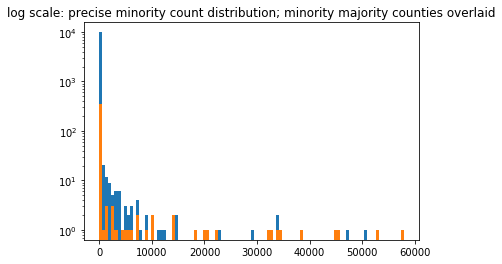

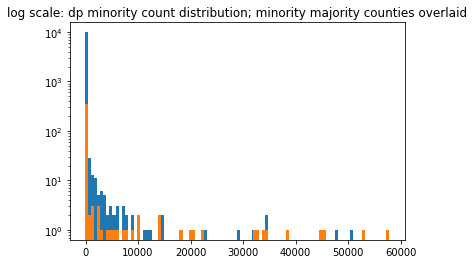

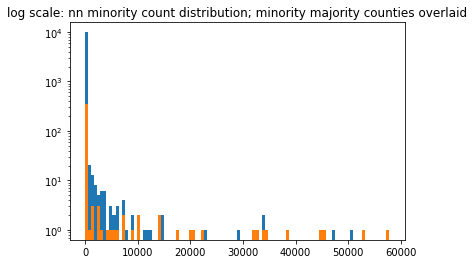

In [13]:
see_minmaj_distr(pop_3e7, version = "precise", use_log = True)
see_minmaj_distr(pop_3e7, version = "dp", use_log = True)
see_minmaj_distr(pop_3e7, version = "nn", use_log = True)

In [14]:
def nonnegative_optimize_mad(imprecise_counts, control_total):
    """optimize the imprecise counts so that they sum to
    the control total and are non-negative
    
    Parameters
    ----------
    imprecise_counts : list-like of floats
    control_total : float
    
    Results
    -------
    returns optimized_counts, which are close to imprecise counts,
    but not negative, and match control total in aggregate
    """
    imprecise_counts = list(imprecise_counts)
    
    model = ConcreteModel()
    model.I = range(len(imprecise_counts))
    model.x = Var(model.I, within=NonNegativeReals)
    model.objective = Objective(
        expr=sum(abs(model.x[i] - imprecise_counts[i]) for i in model.I))
    model.constraint = Constraint(
        expr=summation(model.x) == control_total)
    
    solver = SolverFactory('ipopt')
    results = solver.solve(model, options={'acceptable_tol':1e-4}, tee=False)
    optimized_counts = [value(model.x[i]) for i in model.I]
        
    return np.array(optimized_counts)

In [16]:
def nonnegative_optimize_weighted(imprecise_counts, control_total):
    """optimize the imprecise counts so that they sum to
    the control total and are non-negative
    
    Parameters
    ----------
    imprecise_counts : list-like of floats
    control_total : float
    
    Results
    -------
    returns optimized_counts, which are close to imprecise counts,
    but not negative, and match control total in aggregate
    """
    def f(x):
        k = np.quantile(imprecise_counts, .999)
        if x < k:
            return x**2
        else:
            return 2*(x**2)
        
    
    imprecise_counts = list(imprecise_counts)
    
    model = ConcreteModel()
    model.I = range(len(imprecise_counts))
    model.x = Var(model.I, within=NonNegativeReals)
    model.objective = Objective(
        expr=sum(abs(imprecise_counts[i])*(model.x[i] - imprecise_counts[i])**2 for i in model.I))
    model.constraint = Constraint(
        expr=summation(model.x) == control_total)
    
    solver = SolverFactory('ipopt')
    results = solver.solve(model, options={'acceptable_tol':1e-4}, tee=False)
    optimized_counts = [value(model.x[i]) for i in model.I]
        
    return np.array(optimized_counts)

In [22]:
pop_3e5_weighted = main(nonnegative_optimize_weighted, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e5, epsilon=0.1, seed=1)

In [23]:
summaries(pop_3e5_weighted)

,minority majority totals,minority minority totals
precise,5649.000000,4190.000000
dp,5604.000000,3111.000000
non-neg,5220.691454,4618.308576
pct change,0.068399,-0.484509


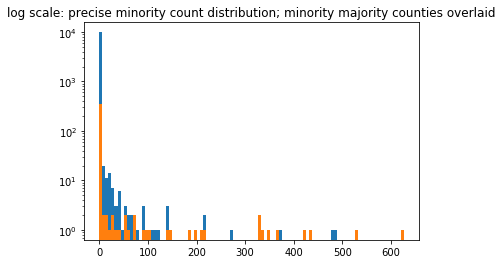

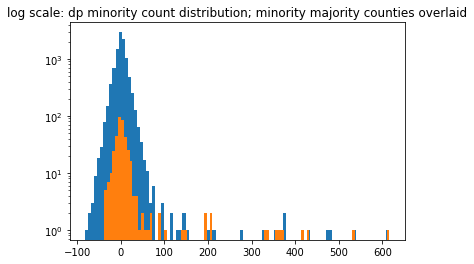

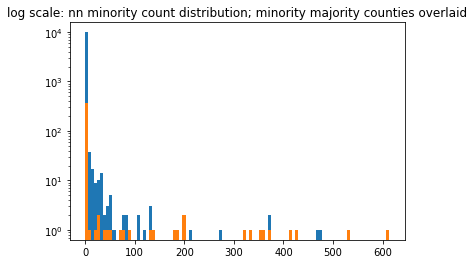

In [24]:
see_minmaj_distr(pop_3e5_weighted, version = "precise", use_log = True)
see_minmaj_distr(pop_3e5_weighted, version = "dp", use_log = True)
see_minmaj_distr(pop_3e5_weighted, version = "nn", use_log = True)

In [25]:
def nonnegative_optimize_sq_weighted(imprecise_counts, control_total):
    """optimize the imprecise counts so that they sum to
    the control total and are non-negative
    
    Parameters
    ----------
    imprecise_counts : list-like of floats
    control_total : float
    
    Results
    -------
    returns optimized_counts, which are close to imprecise counts,
    but not negative, and match control total in aggregate
    """      
    
    imprecise_counts = list(imprecise_counts)
    
    model = ConcreteModel()
    model.I = range(len(imprecise_counts))
    model.x = Var(model.I, within=NonNegativeReals)
    model.objective = Objective(
        expr=sum((imprecise_counts[i]**2)*(model.x[i] - imprecise_counts[i])**2 for i in model.I))
    model.constraint = Constraint(
        expr=summation(model.x) == control_total)
    
    solver = SolverFactory('ipopt')
    results = solver.solve(model, options={'acceptable_tol':1e-4}, tee=False)
    optimized_counts = [value(model.x[i]) for i in model.I]
        
    return np.array(optimized_counts)

In [27]:
pop_3e3_sq_weighted = main(nonnegative_optimize_sq_weighted, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e3, epsilon=0.1, seed=1)

In [28]:
pop_3e5_sq_weighted = main(nonnegative_optimize_sq_weighted, a=.02, b=10, pct_minority=.05, segregation_factor=1, K=10_000, N=3e5, epsilon=0.1, seed=1)

In [30]:
summaries(pop_3e3_sq_weighted)

,minority majority totals,minority minority totals
precise,50.000000,37.000000
dp,-225.000000,-780.000000
non-neg,6.054479,80.945620
pct change,1.026909,1.103776


In [31]:
summaries(pop_3e5_sq_weighted)

,minority majority totals,minority minority totals
precise,5649.000000,4190.000000
dp,5604.000000,3111.000000
non-neg,5316.755351,4522.244747
pct change,0.051257,-0.453631


In [ ]:
summaries(pop_3e7_sq_weighted)

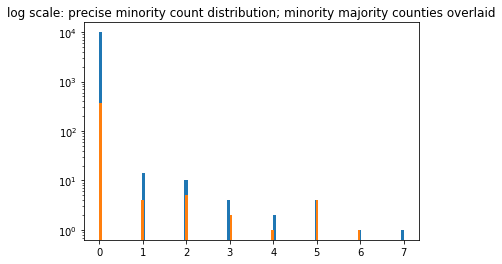

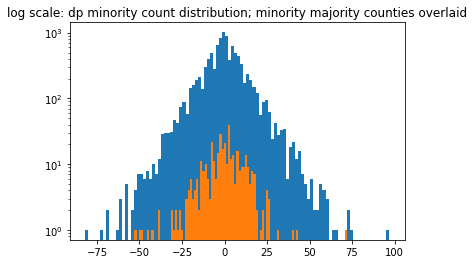

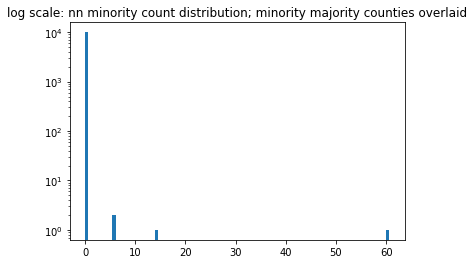

In [32]:
see_minmaj_distr(pop_3e3_sq_weighted, version = "precise", use_log = True)
see_minmaj_distr(pop_3e3_sq_weighted, version = "dp", use_log = True)
see_minmaj_distr(pop_3e3_sq_weighted, version = "nn", use_log = True)

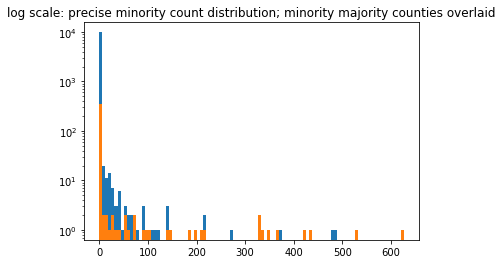

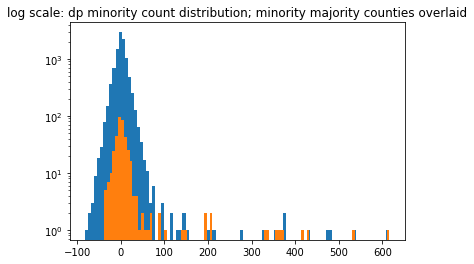

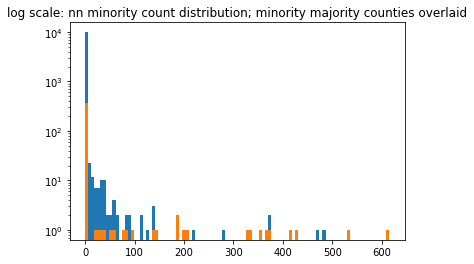

In [33]:
see_minmaj_distr(pop_3e5_sq_weighted, version = "precise", use_log = True)
see_minmaj_distr(pop_3e5_sq_weighted, version = "dp", use_log = True)
see_minmaj_distr(pop_3e5_sq_weighted, version = "nn", use_log = True)

In [ ]:
see_minmaj_distr(pop_3e7_sq_weighted, version = "precise", use_log = True)
see_minmaj_distr(pop_3e7_sq_weighted, version = "dp", use_log = True)
see_minmaj_distr(pop_3e7_sq_weighted, version = "nn", use_log = True)